In [20]:
'''
loading and setting up the data
'''
import pandas as pd

# list of target variables:
target_variables = ['dep_score','dep_thoughts','has_dep_diag','panic_score',
                    'prim_diag','secd_diag']

target_variables_drop = ['dep_thoughts','secd_diag','has_dep_diag',
                    'panic_score','prim_diag']  # target variable = dep_score

# irrelevant features:
redundant_features = ['sex','height_16']

non_screentime_features = ['agg_score', 'alon_week', 'alon_wend', 'anx_band_07', 'anx_band_10', 
                           'anx_band_13', 'anx_band_15', 'birth_order', 'child_bull', 'creat_14', 
                           'dep_band_07', 'dep_band_10', 'dep_band_13', 'dep_band_15', 'draw_week', 
                           'draw_wend', 'emot_cruel', 'exercise', 'iq', 'mat_age', 
                           'mat_anx_0m', 'mat_anx_1', 'mat_anx_18m', 'mat_anx_8m', 'mat_dep', 'mat_edu', 
                           'mat_ses', 'musi_13', 'musi_week', 'musi_wend', 'num_home', 'out_sum_week', 
                           'out_sum_wend', 'out_win_week', 'out_win_wend', 'parity', 'pat_edu', 'pat_pres', 
                           'pat_pres_10', 'pat_pres_8', 'pat_ses', 'phone_14_week', 'phone_14_wend', 'phys_cruel', 
                           'play_week', 'play_wend', 'read_week', 'read_wend', 'talk_phon_week', 
                           'talk_phon_wend', 'tran_week', 'tran_wend', 'work_week', 'work_wend','bmi_16']

df = pd.read_csv('/Users/trekz1/Documents/Applied Data Sci/Coursework/screenTime/numeric-maps-synthetic-data-v1.1.csv')

dep_score = df[['dep_score']]  # load target variable
dep_score = dep_score.dropna()  # drop nans from target variable

df = df.drop(non_screentime_features, axis=1)
df = df.drop(redundant_features, axis=1)  # drop irrelevant features

df1 = df.loc[dep_score.index]   # locate indices of remaining rows of dep_score & create dataframe
df1 = df1.drop(target_variables_drop,axis=1)   # drop the other target variables 

df1 = df1.fillna(df1.mode().iloc[0])  # mode imputing the features 

print(df1.shape)

X = df1.drop('dep_score',axis=1)
y = df1['dep_score']

print(X.shape)
print(y.shape)

(4513, 20)
(4513, 19)
(4513,)


In [21]:
'''
splitting data into train-test-val & normalising
'''

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import keras_tuner as kt
import shutil

# train:test:val = 0.8:0.1:0.1
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

input_shape = X_train_scaled.shape[1:]




In [22]:
'''
RMSE function
'''
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))  # RMSE

In [23]:
'''
plot histories function
'''

def plot_history(history, filename='training_history.png'):
    # Plotting Training and Validation Loss
    plt.figure(figsize=(14, 5))
    
    # Subplot for the loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'b-', label='Training Loss')
    plt.plot(history.history['val_loss'], 'r-', label='Validation Loss')
#     plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
#     # Subplot for the MAE
#     plt.subplot(1, 3, 2)
#     plt.plot(history.history['mae'], 'b-', label='Training MAE')
#     plt.plot(history.history['val_mae'], 'r-', label='Validation MAE')
# #     plt.title('Training and Validation MAE')
#     plt.xlabel('Epochs')
#     plt.ylabel('MAE')
#     plt.legend()
    
    # subplot for RMSE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['root_mean_squared_error'], 'b-', label='Training RMSE')
    plt.plot(history.history['val_root_mean_squared_error'], 'r-', label='Validation RMSE')
#     plt.title('Training and Validation RMSE')
    plt.xlabel('Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(filename)  # Save the plot to a file
    plt.show()



In [24]:
'''
Hyperparameter tuning function
'''
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers
from keras_tuner.engine.hyperparameters import HyperParameters

def build_model(hp):
    model = Sequential([
        layers.Dense(
            hp.Int('units_1', min_value=128, max_value=512, step=64),
            activation='relu',
            input_dim=input_shape[0],
            kernel_regularizer=regularizers.l1_l2(
                l1=hp.Float('l1_1', min_value=0.0001, max_value=0.001, sampling='log'),
                l2=hp.Float('l2_1', min_value=0.0001, max_value=0.001, sampling='log')
            )
        ),
        layers.Dropout(hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),
        layers.Dense(
            hp.Int('units_2', min_value=128, max_value=512, step=64),
            activation='relu',
            kernel_regularizer=regularizers.l1_l2(
                l1=hp.Float('l1_2', min_value=0.0001, max_value=0.001, sampling='log'),
                l2=hp.Float('l2_2', min_value=0.0001, max_value=0.001, sampling='log')
            )
        ),
        layers.Dropout(hp.Float('dropout_2', min_value=0.2, max_value=0.5, step=0.1)),
        layers.Dense(1)
    ])
    model.compile(
        optimizer=SGD(
            learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log'),
            momentum=hp.Float('momentum', min_value=0.5, max_value=1.0, step=0.1),
            nesterov=True
        ),
        loss='mse',
        metrics=['mae', root_mean_squared_error]
    )
    return model


In [25]:
# def build_model(hp):
#     model = Sequential()
#     model.add(layers.Dense(
#         hp.Int('units', min_value=32, max_value=512, step=32),
#         activation='relu', 
#         input_dim=input_shape[0]))  # Corrected: use `input_dim` for 1D input
#     model.add(layers.Dropout(
#         hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
#     model.add(layers.Dense(
#         hp.Int('units', min_value=32, max_value=512, step=32),
#         activation='relu'))
#     model.add(layers.Dropout(
#         hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
#     model.add(layers.Dense(1))
#     model.compile(optimizer=tf.keras.optimizers.Adam(
#         hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
#         loss='mse', metrics=['mae'])
#     return model

In [26]:
# '''
# Running the tuner
# '''
# from keras_tuner.tuners import RandomSearch

# # tuner_dir = 'keras_tuner/model_tuning'
# # shutil.rmtree(tuner_dir, ignore_errors=False)  # `ignore_errors=True` to avoid errors if the directory does not exist


# tuner = kt.RandomSearch(
#     build_model,
#     objective='val_mae',
#     max_trials=1000,
#     executions_per_trial=1,
#     directory='keras_tuner',
#     project_name='model_tuning'
# )

# # Run the hyperparameter search
# tuner.search(
#     X_train_scaled,
#     y_train,
#     epochs=20,
#     validation_data=(X_val_scaled, y_val),
#     verbose=2
# )


# # If you want to get information about the best trial
# best_trial = tuner.oracle.get_best_trials(num_trials=1)[0]
# print(f"Best trial ID: {best_trial.trial_id}")

# # You can now get the hyperparameters directly from the best trial object
# best_hyperparameters = best_trial.hyperparameters


# # Print each hyperparameter and its corresponding value
# for name, value in best_hyperparameters.values.items():
#     print(f"{name}: {value}")


In [27]:
def r_squared(y_true, y_pred):  # r-squared function to use with keras
    residual = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
    total = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
    r2 = tf.subtract(1.0, tf.divide(residual, total))
    return r2

In [28]:
def create_model(input_shape):  
    # define model architecture
    model = Sequential([
        layers.Dense(320, activation='relu', 
                     input_dim=input_shape[0],
                     kernel_regularizer=regularizers.l1_l2(l1=0.0004028421982307429, 
                                                           l2=0.0002321252535748304)),  # Elastic net regularization,
        layers.Dropout(0.4), 
        layers.Dense(512, activation='relu', 
                     kernel_regularizer=regularizers.l1_l2(l1=0.00014452386919715736, 
                                                           l2=0.0002586741362408494)),
        layers.Dropout(0.3), 
        layers.Dense(1)
    ])
    # compile model
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.00010461742993618505, momentum=0.5, nesterov=True),
                  loss='mse', metrics=['mae', root_mean_squared_error, r_squared])  # mse is a common loss function for regression tasks, 
                                                # mae as a regression measure
    return model

Epoch 1/200
113/113 - 2s - loss: 2.2761 - mae: 0.5951 - root_mean_squared_error: 0.9772 - r_squared: -2.1182e-01 - val_loss: 2.1945 - val_mae: 0.5474 - val_root_mean_squared_error: 0.8732 - val_r_squared: -inf - 2s/epoch - 14ms/step
Epoch 2/200
113/113 - 0s - loss: 2.2439 - mae: 0.6276 - root_mean_squared_error: 0.9559 - r_squared: -1.7119e-01 - val_loss: 2.1726 - val_mae: 0.5832 - val_root_mean_squared_error: 0.8699 - val_r_squared: -inf - 480ms/epoch - 4ms/step
Epoch 3/200
113/113 - 0s - loss: 2.2260 - mae: 0.6458 - root_mean_squared_error: 0.9492 - r_squared: -1.4793e-01 - val_loss: 2.1658 - val_mae: 0.6014 - val_root_mean_squared_error: 0.8705 - val_r_squared: -inf - 428ms/epoch - 4ms/step
Epoch 4/200
113/113 - 0s - loss: 2.2215 - mae: 0.6557 - root_mean_squared_error: 0.9461 - r_squared: -2.0885e-01 - val_loss: 2.1622 - val_mae: 0.6133 - val_root_mean_squared_error: 0.8713 - val_r_squared: -inf - 430ms/epoch - 4ms/step
Epoch 5/200
113/113 - 0s - loss: 2.2215 - mae: 0.6637 - root_m

Epoch 36/200
113/113 - 1s - loss: 2.1803 - mae: 0.6683 - root_mean_squared_error: 0.9327 - r_squared: -8.5216e-02 - val_loss: 2.1428 - val_mae: 0.6277 - val_root_mean_squared_error: 0.8693 - val_r_squared: -inf - 536ms/epoch - 5ms/step
Epoch 37/200
113/113 - 1s - loss: 2.1875 - mae: 0.6703 - root_mean_squared_error: 0.9322 - r_squared: -1.1747e-01 - val_loss: 2.1426 - val_mae: 0.6271 - val_root_mean_squared_error: 0.8691 - val_r_squared: -inf - 525ms/epoch - 5ms/step
Epoch 38/200
113/113 - 0s - loss: 2.1937 - mae: 0.6683 - root_mean_squared_error: 0.9359 - r_squared: -1.2325e-01 - val_loss: 2.1424 - val_mae: 0.6272 - val_root_mean_squared_error: 0.8692 - val_r_squared: -inf - 496ms/epoch - 4ms/step
Epoch 39/200
113/113 - 1s - loss: 2.1927 - mae: 0.6692 - root_mean_squared_error: 0.9348 - r_squared: -1.2656e-01 - val_loss: 2.1421 - val_mae: 0.6275 - val_root_mean_squared_error: 0.8693 - val_r_squared: -inf - 610ms/epoch - 5ms/step
Epoch 40/200
113/113 - 0s - loss: 2.1780 - mae: 0.6624 -

Epoch 71/200
113/113 - 1s - loss: 2.1670 - mae: 0.6652 - root_mean_squared_error: 0.9215 - r_squared: -1.6626e-01 - val_loss: 2.1357 - val_mae: 0.6312 - val_root_mean_squared_error: 0.8702 - val_r_squared: -inf - 524ms/epoch - 5ms/step
Epoch 72/200
113/113 - 0s - loss: 2.1766 - mae: 0.6687 - root_mean_squared_error: 0.9293 - r_squared: -1.2605e-01 - val_loss: 2.1355 - val_mae: 0.6316 - val_root_mean_squared_error: 0.8702 - val_r_squared: -inf - 473ms/epoch - 4ms/step
Epoch 73/200
113/113 - 1s - loss: 2.1608 - mae: 0.6663 - root_mean_squared_error: 0.9237 - r_squared: -9.1906e-02 - val_loss: 2.1354 - val_mae: 0.6329 - val_root_mean_squared_error: 0.8705 - val_r_squared: -inf - 508ms/epoch - 4ms/step
Epoch 74/200
113/113 - 1s - loss: 2.1668 - mae: 0.6680 - root_mean_squared_error: 0.9215 - r_squared: -1.1673e-01 - val_loss: 2.1352 - val_mae: 0.6316 - val_root_mean_squared_error: 0.8703 - val_r_squared: -inf - 534ms/epoch - 5ms/step
Epoch 75/200
113/113 - 1s - loss: 2.1636 - mae: 0.6632 -

Epoch 106/200
113/113 - 1s - loss: 2.1686 - mae: 0.6737 - root_mean_squared_error: 0.9284 - r_squared: -1.1018e-01 - val_loss: 2.1300 - val_mae: 0.6315 - val_root_mean_squared_error: 0.8704 - val_r_squared: -inf - 550ms/epoch - 5ms/step
Epoch 107/200
113/113 - 0s - loss: 2.1475 - mae: 0.6623 - root_mean_squared_error: 0.9126 - r_squared: -1.2464e-01 - val_loss: 2.1299 - val_mae: 0.6316 - val_root_mean_squared_error: 0.8704 - val_r_squared: -inf - 497ms/epoch - 4ms/step
Epoch 108/200
113/113 - 1s - loss: 2.1512 - mae: 0.6619 - root_mean_squared_error: 0.9158 - r_squared: -1.0111e-01 - val_loss: 2.1298 - val_mae: 0.6338 - val_root_mean_squared_error: 0.8709 - val_r_squared: -inf - 509ms/epoch - 5ms/step
Epoch 109/200
113/113 - 1s - loss: 2.1442 - mae: 0.6622 - root_mean_squared_error: 0.9156 - r_squared: -9.1578e-02 - val_loss: 2.1297 - val_mae: 0.6339 - val_root_mean_squared_error: 0.8710 - val_r_squared: -inf - 760ms/epoch - 7ms/step
Epoch 110/200
113/113 - 1s - loss: 2.1479 - mae: 0.6

Epoch 141/200
113/113 - 1s - loss: 2.1373 - mae: 0.6588 - root_mean_squared_error: 0.9154 - r_squared: -6.5914e-02 - val_loss: 2.1251 - val_mae: 0.6352 - val_root_mean_squared_error: 0.8717 - val_r_squared: -inf - 896ms/epoch - 8ms/step
Epoch 142/200
113/113 - 1s - loss: 2.1451 - mae: 0.6668 - root_mean_squared_error: 0.9178 - r_squared: -9.1860e-02 - val_loss: 2.1250 - val_mae: 0.6345 - val_root_mean_squared_error: 0.8716 - val_r_squared: -inf - 839ms/epoch - 7ms/step
Epoch 143/200
113/113 - 1s - loss: 2.1447 - mae: 0.6656 - root_mean_squared_error: 0.9161 - r_squared: -1.2306e-01 - val_loss: 2.1248 - val_mae: 0.6331 - val_root_mean_squared_error: 0.8712 - val_r_squared: -inf - 771ms/epoch - 7ms/step
Epoch 144/200
113/113 - 1s - loss: 2.1339 - mae: 0.6614 - root_mean_squared_error: 0.9174 - r_squared: -5.1034e-02 - val_loss: 2.1247 - val_mae: 0.6337 - val_root_mean_squared_error: 0.8713 - val_r_squared: -inf - 667ms/epoch - 6ms/step
Epoch 145/200
113/113 - 1s - loss: 2.1453 - mae: 0.6

Epoch 176/200
113/113 - 1s - loss: 2.1336 - mae: 0.6632 - root_mean_squared_error: 0.9148 - r_squared: -7.3218e-02 - val_loss: 2.1205 - val_mae: 0.6343 - val_root_mean_squared_error: 0.8716 - val_r_squared: -inf - 525ms/epoch - 5ms/step
Epoch 177/200
113/113 - 1s - loss: 2.1336 - mae: 0.6644 - root_mean_squared_error: 0.9156 - r_squared: -9.0413e-02 - val_loss: 2.1203 - val_mae: 0.6354 - val_root_mean_squared_error: 0.8719 - val_r_squared: -inf - 560ms/epoch - 5ms/step
Epoch 178/200
113/113 - 1s - loss: 2.1247 - mae: 0.6575 - root_mean_squared_error: 0.9116 - r_squared: -5.7291e-02 - val_loss: 2.1202 - val_mae: 0.6363 - val_root_mean_squared_error: 0.8721 - val_r_squared: -inf - 520ms/epoch - 5ms/step
Epoch 179/200
113/113 - 1s - loss: 2.1301 - mae: 0.6629 - root_mean_squared_error: 0.9124 - r_squared: -5.6654e-02 - val_loss: 2.1202 - val_mae: 0.6356 - val_root_mean_squared_error: 0.8720 - val_r_squared: -inf - 620ms/epoch - 5ms/step
Epoch 180/200
113/113 - 1s - loss: 2.1265 - mae: 0.6

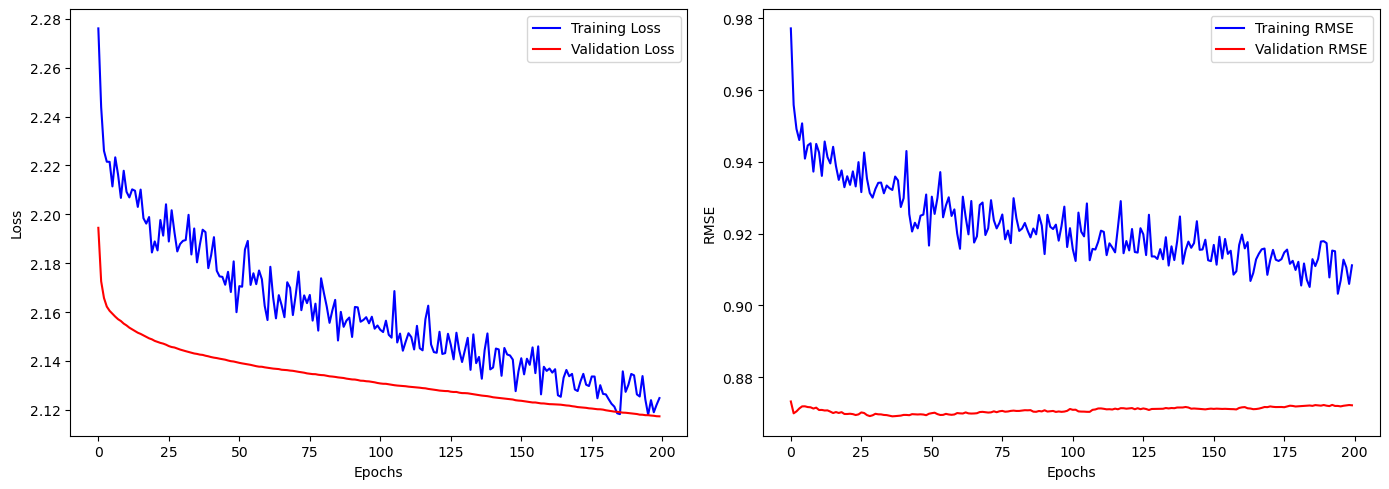

In [29]:

model = create_model(input_shape)

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitors the validation loss
    patience=8,         # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True)  # Restores model weights from the epoch with the lowest validation loss


# train the model
history = model.fit(X_train_scaled,
                    y_train, 
                    validation_data=(X_val_scaled, y_val),
                    epochs=200, 
                    batch_size=32,
                    callbacks=[early_stopping],
                    verbose=2)

# evaluate the model
test_loss, test_mae ,test_rmse, test_r2 = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}, Test R-Squared: {test_r2}")

# call plot function
plot_history(history, filename = 'training_history2')

15/15 [==============================] - 0s 2ms/step - loss: 2.0703 - mae: 0.6315 - root_mean_squared_error: 0.8911 - r_squared: -0.0588
Test Loss: 2.0703184604644775, Test MAE: 0.6314682960510254, Test RMSE: 0.8911157846450806, Test R-Squared: -0.058839451521635056


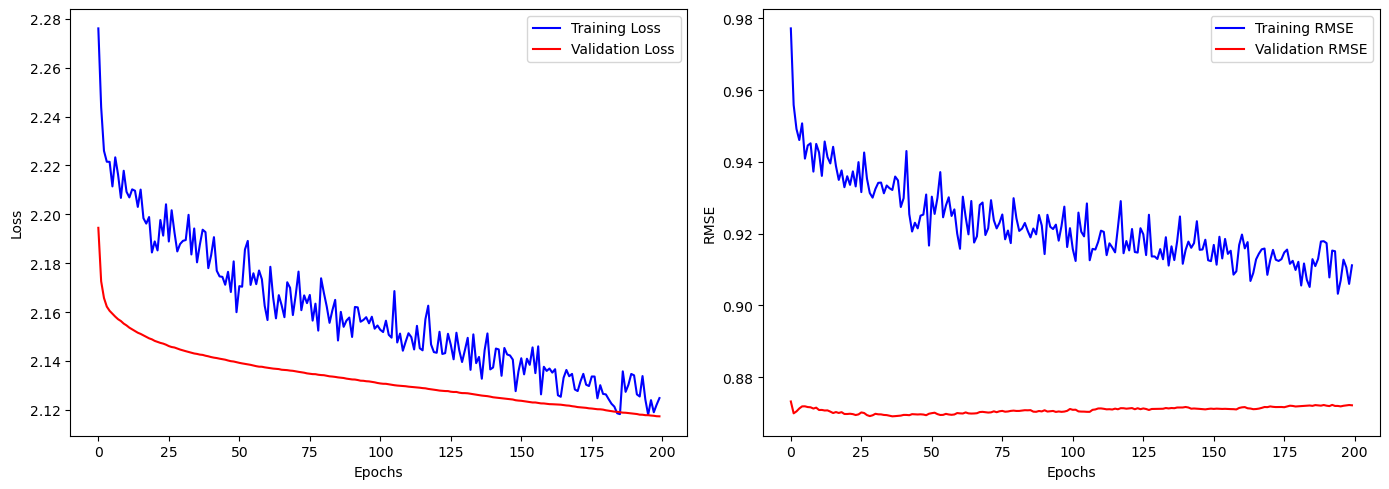

In [30]:
# evaluate the model
test_loss, test_mae ,test_rmse, test_r2 = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}, Test RMSE: {test_rmse}, Test R-Squared: {test_r2}")

# call plot function
plot_history(history, filename = 'training_history_depscore')


In [32]:
presentable_names = {
 'agg_score': 'Aggression Score',
 'alon_week': 'Alone Weekdays 16',
 'alon_wend': 'Alone Weekend 16',
 'anx_band_07': 'Anxiety Band 07',
 'anx_band_10': 'Anxiety Band 10',
 'anx_band_13': 'Anxiety Band 13',
 'anx_band_15': 'Anxiety Band 15',
 'birth_order': 'Birth Order',
 'child_bull': 'Child Bullied',
 'comp_bed_9': 'Computer Bed 09',
 'comp_games': 'Computer Games 05',
 'comp_house': 'Computer No Internet 16',
 'comp_int_bed_16': 'Computer Internet Bed 16',
 'comp_noint_bed_16': 'Computer No Internet Bed 16',
 'comp_week': 'Computer Time Weekday 16',
 'comp_wend': 'Computer Time Weekend 16',
 'creat_14': 'Creative Activities 14',
 'dep_band_07': 'Depression Band 07',
 'dep_band_10': 'Depression Band 10',
 'dep_band_13': 'Depression Band 13',
 'dep_band_15': 'Depression Band 15',
 'dep_score': "Depression Score",
 'dep_thoughts': "Depressive Thoughts",
 'draw_week': 'Time Drawing Weekday 16',
 'draw_wend': 'Time Drawing Weekend 16',
 'emot_cruel': 'Emotionally Cruel',
 'exercise': 'Exercise Frequency 16',
 'fam_tv_aft': 'TV Frequency Afternoons 01',
 'fam_tv_eve': 'Tv Frequency Evenings 01',
 'fam_tv_mor': 'TV Frequency Mornings 01',
 'has_dep_diag': 'Depression Diagnosis',
 'height_16': "Height 16",
 'iq': "IQ 08",
 'mat_age': 'Maternal Age Birth',
 'mat_anx_0m': 'Maternal Anxiety 0m',
 'mat_anx_1': 'Maternal Anxiety 01',
 'mat_anx_18m': 'Maternal Anxiety 18m',
 'mat_anx_8m': 'Maternal Anxiety 8m',
 'mat_dep': "Maternal Postnatal Depression",
 'mat_edu': 'Maternal Education',
 'mat_ses': "Mother's Social Class",
 'musi_13': 'Musical Instrument 13',
 'musi_week': 'Musical Time Weekday 13',
 'musi_wend': 'Musical Time Weekend 13',
 'num_home': 'Number People Home 04',
 'out_sum_week': 'Outside Time Summer Weekday 16',
 'out_sum_wend': 'Outside Time Summer Weekend 16',
 'out_win_week': 'Outside Time Winter Weekday 16',
 'out_win_wend': 'Outside Time Winter Weekend 16',
 'own_mob': 'Own Mobile 10',
 'panic_score': "Panic Score",
 'parity': "Pregnancy Parity",
 'pat_edu': "Paternal Education",
 'pat_pres': 'Paternal Presence 04',
 'pat_pres_10': 'Paternal Presence 10',
 'pat_pres_8': 'Paternal Presence 08',
 'pat_ses': "Paternal Social Class",
 'phone_14_week': 'Weekday Phone 14',
 'phone_14_wend': 'Weekend Phone 14',
 'phys_cruel': 'Physically Cruel',
 'play_week': 'Weekday Social 16',
 'play_wend': 'Weekend Social 16',
 'prim_diag': "Primary Diagnosis",
 'read_week': 'Weekday Reading 16',
 'read_wend': 'Weekend Reading 16',
 'secd_diag': "Secondary Diagnosis",
 'sex': 'Sex',
 'talk_mob_week': 'Mob. Phone Weekday 16',
 'talk_mob_wend': 'Mob. Phone Weekend 16',
 'talk_phon_week': 'Phone Weekday 16',
 'talk_phon_wend': 'Phone weekend 16',
 'text_week': 'Text Weekday 16',
 'text_wend': 'Text Weekend 16',
 'tran_week': 'Transport Weekday 16',
 'tran_wend': 'Transport Weekend 16',
 'tv_bed_16': 'TV Bedroom 16',
 'tv_bed_9': 'TV Bedroom 09',
 'tv_week': 'TV Weekday 16',
 'tv_wend': 'TV Weekend 16',
 'weight_16': "Weight 16",
 'work_week': 'Work Weekday 16',
 'work_wend': 'Work Weekend 16'
}

15/15 [==============================] - 0s 2ms/step


15/15 [==============================] - 0s 2ms/step
Computer Bed 09 importance: 8.899260455583758e-05
Computer No Internet Bed 16 importance: 0.000383757351281
Computer Internet Bed 16 importance: -0.00019469969892154103
Text Weekend 16 importance: 4.6092877487469154e-06
Mob. Phone Weekend 16 importance: 0.00015988231494524775
Computer Time Weekend 16 importance: 0.003090356753417278
TV Weekend 16 importance: 0.0009231592943614753
Text Weekday 16 importance: -0.0007582073195539718
Mob. Phone Weekday 16 importance: 0.00023973319847070407
Computer Time Weekday 16 importance: 0.0019378997805789445
TV Weekday 16 importance: 3.3383633349926e-05
TV Bedroom 09 importance: -0.000684984406180722
Own Mobile 10 importance: -0.00040060725526086527
Computer No Internet 16 importance: 0.0001710672793056367
TV Bedroom 16 importance: 0.00037498804369482384
Computer Games 05 importance: -0.0007695639717632541
Tv Frequency Evenings 01 importance: -2.1053182504671142e-05
TV Frequency Afternoons 01 impor

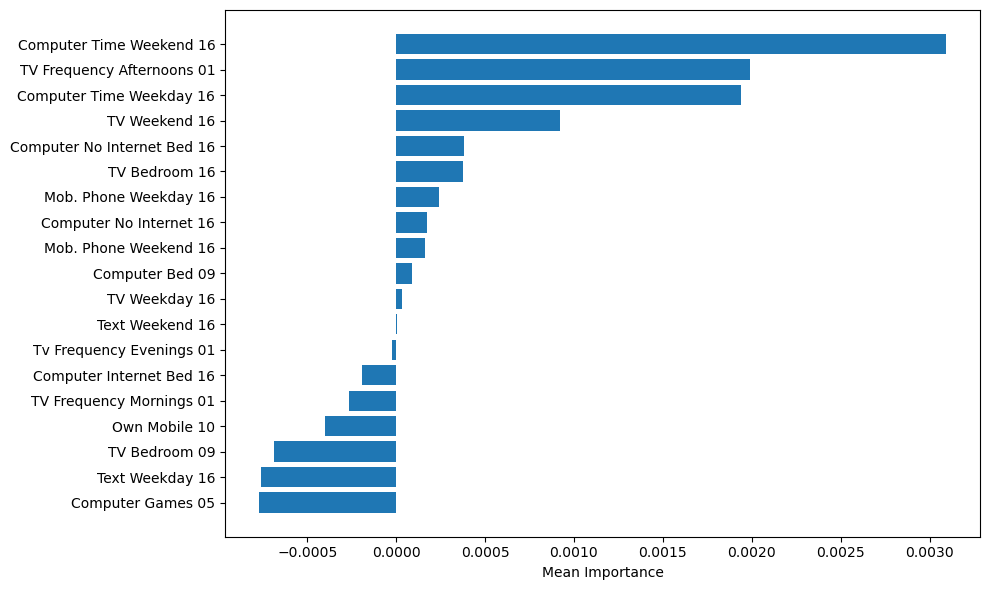

In [36]:
from sklearn.inspection import permutation_importance
import numpy as np

# Define a custom scoring function that can be understood by scikit-learn's permutation_importance function
def custom_scoring_function(estimator, X, y):
    # Use the model to make predictions
    y_pred = estimator.predict(X).flatten()  # Flatten to ensure matching dimensions with y
    # Calculate and return the negative MSE to maintain consistency with scikit-learn's scoring conventions
    return -root_mean_squared_error(y, y_pred)

# Wrap your TensorFlow model to use the predict function directly
# This wrapper will make the model compatible with scikit-learn's expected interface
class KerasRegressorWrapper:
    def __init__(self, model):
        self.model = model
    
    def predict(self, X):
        return self.model.predict(X).flatten()
    
    def fit(self, X, y):
        # No-op fit method to satisfy scikit-learn's interface requirements
        pass

feature_names = X.columns     
    
# Wrap the trained TensorFlow model
wrapped_model = KerasRegressorWrapper(model)

# Ensure 'feature_names' matches the features used in 'X_test'
assert len(feature_names) == X_test.shape[1], "Feature names list doesn't match the number of features in X_test."

# Calculate permutation feature importance using the custom scoring function
permutation_result = permutation_importance(wrapped_model, X_test, y_test, n_repeats=10, random_state=42, scoring=custom_scoring_function)

importances = permutation_result.importances_mean

# Print the feature names with their importances using presentable names
for i, importance in enumerate(importances):
    presentable_name = presentable_names.get(feature_names[i], feature_names[i])  # Fallback to raw name if no presentable name found
    print(f"{presentable_name} importance: {importance}")

import matplotlib.pyplot as plt

# Map the raw feature names to presentable names for plotting
presentable_feature_names = [presentable_names.get(name, name) for name in feature_names]

# Sort the dictionary by importance values using presentable names
importance_dict = dict(zip(presentable_feature_names, importances))
sorted_importances = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Extract the sorted indices for ordering in the bar chart
sorted_indices = np.argsort([importance for _, importance in sorted_importances])[::-1]

# Create the figure and the bar chart using presentable names
plt.figure(figsize=(10, 6))
plt.barh(range(len(importances)), [importance for _, importance in sorted_importances], align='center')
plt.yticks(range(len(importances)), [name for name, _ in sorted_importances])
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.xlabel('Mean Importance')
# plt.title('Permutation Feature Importance')
plt.tight_layout()  # Adjust the layout to fit all labels
plt.savefig('feature_importance')
# Show the plot
plt.show()

# # Baseline mean squared error (MSE) without any permutation
# baseline_mse = -custom_scoring_function(wrapped_model, X_test, y_test)

# # Calculate relative changes in error
# relative_changes = (permutation_result.importances_mean / baseline_mse) * 100

# # Sort the relative changes in descending order and get the indices
# relative_changes_np = relative_changes.numpy()
# sorted_indices = relative_changes_np.argsort()[::-1]

# # Create the figure and the bar chart for relative changes
# plt.figure(figsize=(10, 8))
# plt.barh(range(len(importances)), relative_changes[sorted_indices], align='center')
# plt.yticks(range(len(importances)), [feature_names[i] for i in sorted_indices])
# plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
# plt.xlabel('Percentage Change in MSE')
# plt.title('Permutation Feature Importance (Percentage Change)')
# plt.tight_layout()  # Adjust the layout to fit all labels

# # save and show the plot
# plt.savefig('feature_importance_dep_score.png')
# plt.show()

